In [2]:
!pip install --upgrade pip
!pip install optuna
!pip install yfinance
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 2.6 MB/s eta 0:00:00


In [3]:
from sklearn.model_selection import train_test_split
import time
import copy
import numpy as np
import pandas as pd
import yfinance as yf
import optuna
import tensorflow as tf
from plotly import tools
from plotly.graph_objs import *
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
init_notebook_mode()

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
stock_start_date = '2005-01-01'
stock_end_date = '2023-01-01'

data = yf.download('GOOGL', start= stock_start_date, end=stock_end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4531 entries, 2005-01-03 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4531 non-null   float64
 1   High       4531 non-null   float64
 2   Low        4531 non-null   float64
 3   Close      4531 non-null   float64
 4   Adj Close  4531 non-null   float64
 5   Volume     4531 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 247.8 KB


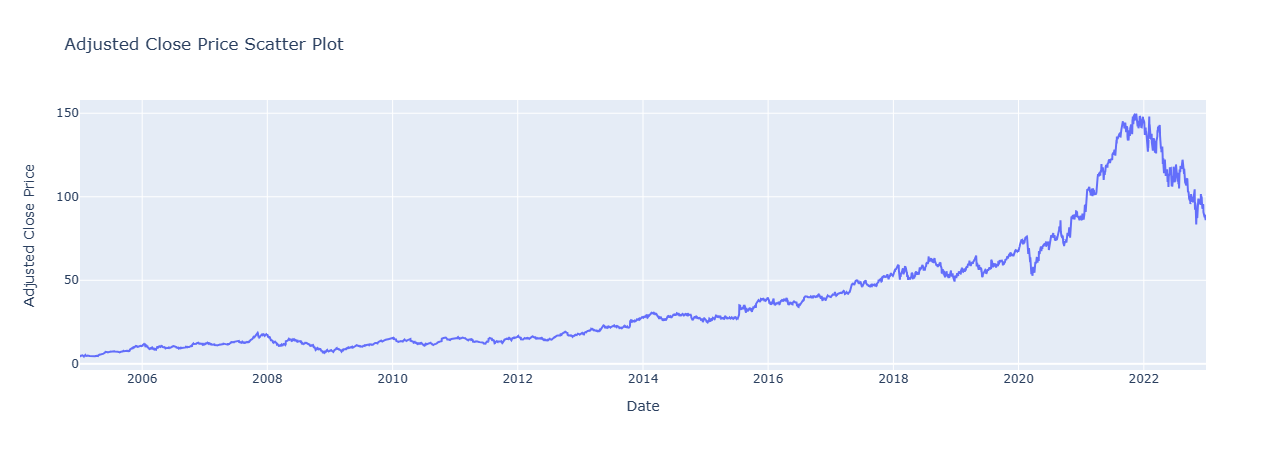

In [6]:
fig = go.Figure(data = go.Scatter(x = data.index , y = data['Adj Close']))
fig.update_layout(title='Adjusted Close Price Scatter Plot',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

fig.show()

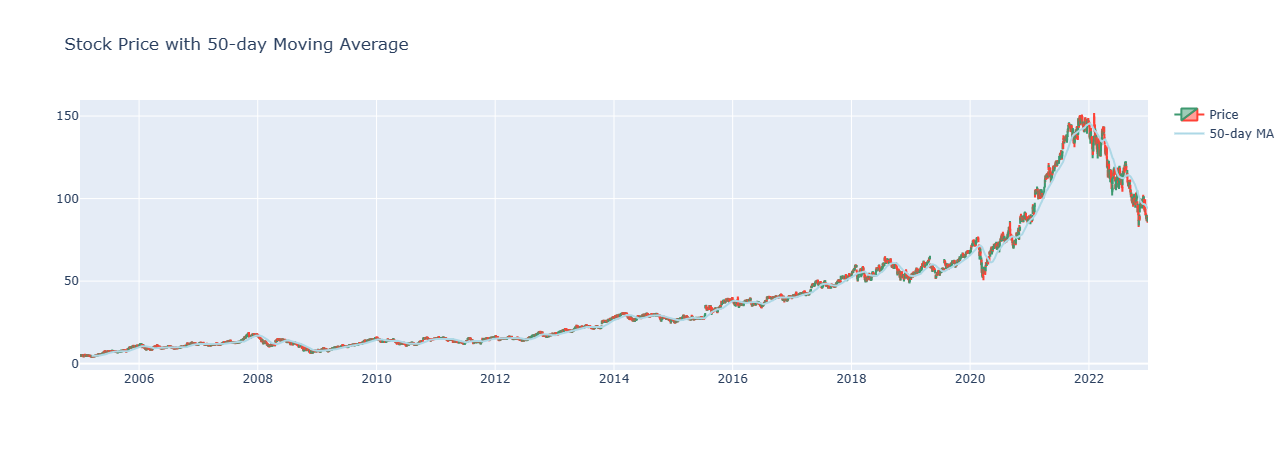

In [7]:
# Calculate the moving average of 50 days
data['MA_50'] = data['Adj Close'].rolling(window=50).mean()

# Plotting the candlestick chart with the moving averages
fig = go.Figure(data=[
    go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Adj Close'], name='Price'),
    go.Scatter(x=data.index, y=data['MA_50'], name='50-day MA', line=dict(color='lightblue'))
])

fig.update_layout(
    title='Stock Price with 50-day Moving Average',
    xaxis_rangeslider_visible=False
)

fig.show()

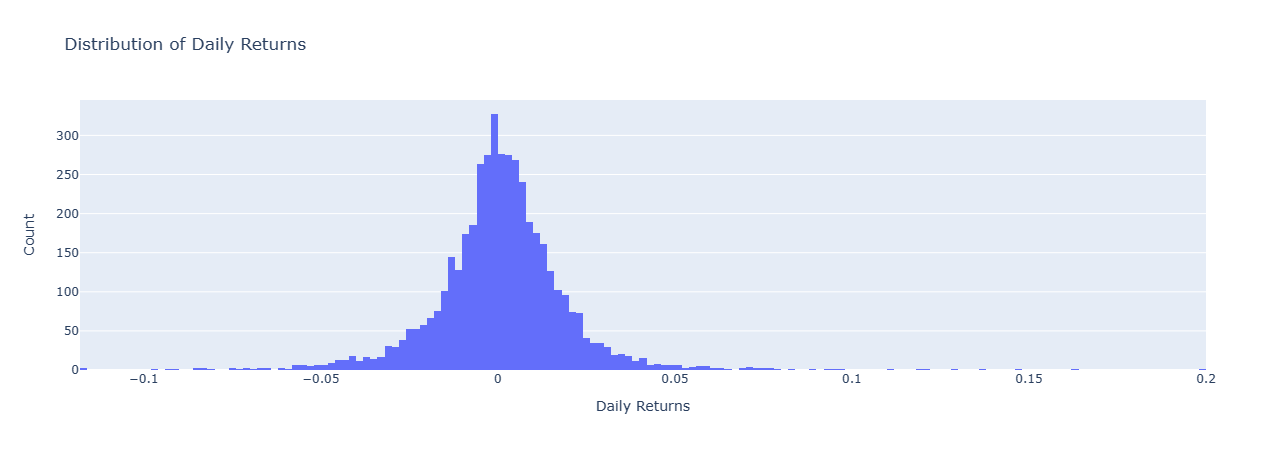

In [8]:
data['Daily Returns'] = data['Adj Close'].pct_change()

fig = go.Figure()

data_dr = data['Daily Returns'].dropna()
fig.add_trace(go.Histogram(x=data_dr, nbinsx=200))

fig.update_layout(
    title='Distribution of Daily Returns',
    xaxis_title='Daily Returns',
    yaxis_title='Count'
)

fig.show()

In [9]:
split_ratio = 0.6
split_index = int(len(data)*split_ratio)
train = data[:split_index]
test = data[split_index:]

In [10]:
# Calculate the number of days
num_days = len(test)
data = test
num_days

1813

In [11]:
days = num_days
dt = 1 / days
data_dr.dropna(inplace = True)
data_dr.head()

Date
2005-01-04   -0.040501
2005-01-05   -0.005090
2005-01-06   -0.025632
2005-01-07    0.028109
2005-01-10    0.006242
Name: Daily Returns, dtype: float64

In [12]:
mu = data_dr.mean()
sigma = data_dr.std()  #volatility

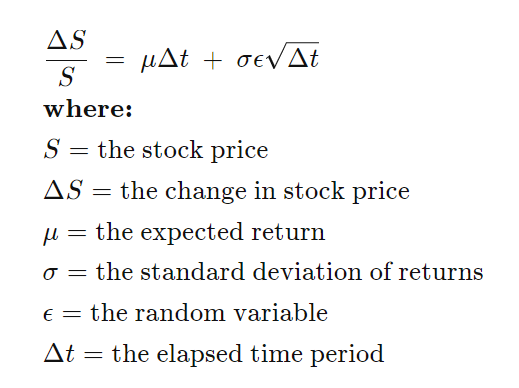

Source : https://www.investopedia.com/articles/07/montecarlo.asp

In [13]:
def monte_carlo(start_price, days, mu, sigma):
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1, days):
        shock[x] = np.random.normal(loc=mu * dt, scale=sigma*np.sqrt(dt))
        drift[x] = mu * dt
        
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

The start price of the stock :  88.2300033569336


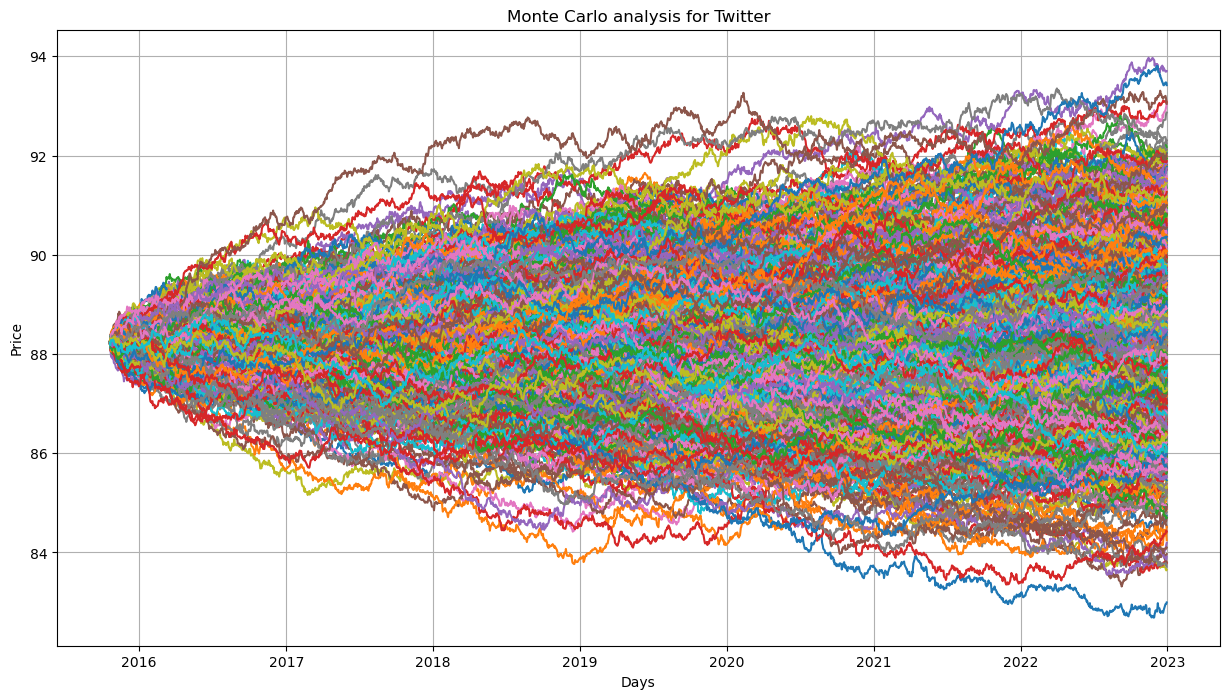

In [15]:
start_price = data['Adj Close'][-1]
print("The start price of the stock : " , start_price)

plt.figure(figsize=(15, 8))
dates = data.index

NUM_SIMULATIONS = 1000
sim = np.zeros(NUM_SIMULATIONS)
for i in range(NUM_SIMULATIONS):
    result = monte_carlo(start_price, days, mu, sigma)
    sim[i] = result[days - 1]
    plt.plot(dates,result)
    
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo analysis for Twitter')
plt.grid(True)  # Add grid lines
plt.show()

In [17]:
# Calculate Sharpe ratio
risk_free_rate = 0.02  # Assuming a risk-free rate of 2%
daily_rf_rate = (1 + risk_free_rate) ** (1 / days) - 1
excess_returns = sim - start_price
volatility = np.std(excess_returns)
sharpe_ratio = (np.mean(excess_returns) - daily_rf_rate) / volatility

# Calculate Value at Risk (VaR)
confidence_level = 0.95
var = np.percentile(sim - start_price, (1 - confidence_level) * 100)

# Print the results
print("Expected price: ", round(np.mean(sim), 2))
print("Quantile (5%): ", np.percentile(sim, 5))
print("Quantile (95%): ", np.percentile(sim, 95))
print("Sharpe Ratio: ", round(sharpe_ratio, 2))
print("Value at Risk (VaR): ", round(var, 2))

Expected price:  88.31
Quantile (5%):  85.74311503832546
Quantile (95%):  91.0890415299491
Sharpe Ratio:  0.05
Value at Risk (VaR):  -2.49


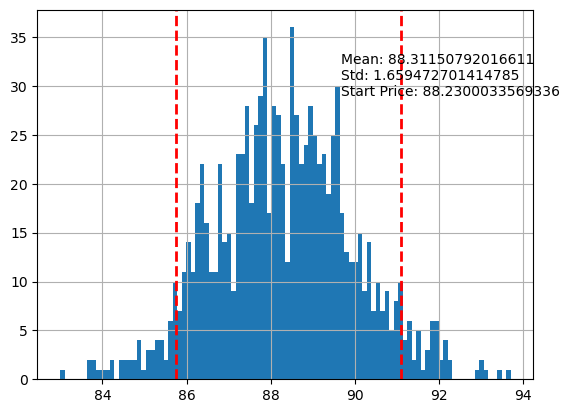

In [18]:
plt.hist(sim,bins=100)
plt.axvline(np.percentile(sim,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(sim,95), color='r', linestyle='dashed', linewidth=2)
plt.figtext(0.6, 0.7, "Mean: {} \nStd: {} \nStart Price: {}".format(sim.mean(), sim.std(), start_price))
plt.grid(True)  # Add grid lines
plt.show()

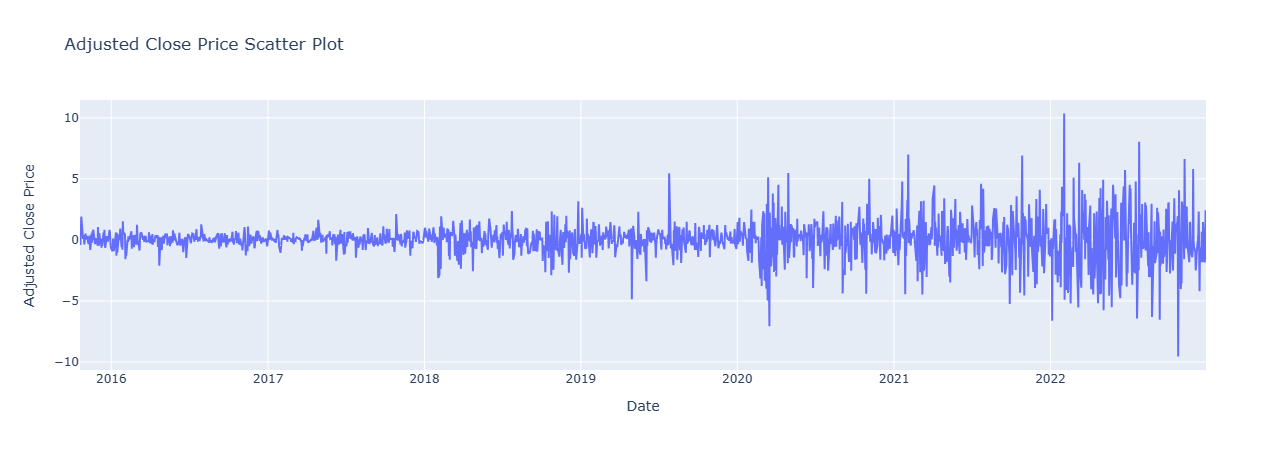

In [19]:
df = data.copy()
df['diff_Close'] = df['Adj Close'] - df['Adj Close'].shift(1)
fig = go.Figure(data = go.Scatter(x = df.index , y = df['diff_Close']))
fig.update_layout(title='Adjusted Close Price Scatter Plot',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')
fig.show()

In [21]:
from statsmodels.tsa.stattools import adfuller
#data['logged_and_diffed'] = np.log(data['Adj Close']) - np.log(data['Adj Close']).shift(1)
dftest = adfuller(df['diff_Close'].values[1:], autolag="AIC")
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                -9.784834e+00
p-value                        6.585715e-17
#Lags Used                     2.100000e+01
Number of Observations Used    1.790000e+03
Critical Value (1%)           -3.434008e+00
Critical Value (5%)           -2.863156e+00
Critical Value (10%)          -2.567630e+00
dtype: float64


In [22]:
test.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2015-10-20  34.894501  34.900002  33.683998  34.000000  34.000000   52434000   
2015-10-21  34.160500  34.244999  33.535000  33.590000  33.590000   31952000   
2015-10-22  33.771999  34.402500  33.584999  34.056999  34.056999   88632000   
2015-10-23  37.502998  37.625000  35.896999  35.966499  35.966499  126726000   
2015-10-26  36.000999  36.747501  36.000999  36.556000  36.556000   48776000   

               MA_50  Daily Returns  
Date                                 
2015-10-20  33.08624      -0.028502  
2015-10-21  33.06774      -0.012059  
2015-10-22  33.05741       0.013903  
2015-10-23  33.09023       0.056068  
2015-10-26  33.13198       0.016390

In [ ]:
def plot_train_test(train, test, date_split):
    
    data = [
        Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Adj Close'], name='train'),
        Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Adj Close'], name='test')
    ]
    layout = {
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)

In [ ]:
date_split = train.index[-1]
date_split
plot_train_test(train, test, date_split)

In [21]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        self.total_investment = 0  # Initialize total investment
        return [self.position_value] + self.history  # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Adj Close'])
            self.total_investment += self.data.iloc[self.t, :]['Adj Close']  # Increment total investment
        elif act == 2:  # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Adj Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Adj Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Adj Close'] - self.data.iloc[(self.t-1), :]['Adj Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done  # obs, reward, done

In [22]:
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact) , pact)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.20545625686645508], 0, False) 0
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.20545625686645508, -0.024773597717285156], -1, False) 2
([-0.12412500381469727, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [23]:
train.tail()

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2015-10-13  33.713001  34.423000  33.655499  34.158501  34.158501  42446000   
2015-10-14  34.186501  34.501999  33.945000  34.020500  34.020500  31292000   
2015-10-15  34.262501  34.708000  34.219501  34.651001  34.651001  47156000   
2015-10-16  34.770000  34.811001  34.455002  34.765999  34.765999  36316000   
2015-10-19  34.700001  35.012001  34.610500  34.997501  34.997501  30172000   

               MA_50  Daily Returns  diff_Close  
Date                                             
2015-10-13  32.96979       0.009964    0.337002  
2015-10-14  32.98892      -0.004040   -0.138000  
2015-10-15  33.00865       0.018533    0.630501  
2015-10-16  33.03382       0.003319    0.114998  
2015-10-19  33.06938       0.006659    0.231503

In [24]:
class Q_Network(tf.keras.Model):

    def __init__(self, input_size, hidden_size, output_size):
        super(Q_Network, self).__init__()
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.fc2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.fc3 = tf.keras.layers.Dense(output_size)

    def call(self, x):
        h = self.fc1(x)
        h = tf.nn.relu(h)
        h = self.fc2(h)
        h = tf.nn.relu(h)
        y = self.fc3(h)
        return y

    def reset(self):
        self.optimizer.zero_grad()

In [25]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [26]:
def train_dqn(env, hidden_size, memory_size, epsilon, epsilon_decrease, epsilon_min,
              start_reduce_epsilon, train_freq, update_q_freq, gamma, show_log_freq, epoch_num , learning_rate):

    Q = Q_Network(input_size=env.history_t + 1, hidden_size=hidden_size, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    batch_size = 20
    step_max = len(env.data) - 1
    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    start = time.time()

    with tf.device('/gpu:0'):
        for epoch in range(epoch_num):
            pobs = env.reset()
            step = 0
            done = False
            total_reward = 0
            total_loss = 0

            while not done and step < step_max:
                 # select action
                pact = np.random.randint(3)
                if np.random.rand() > epsilon:
                    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                    pact = np.argmax(pact.numpy())
                # take action
                obs, reward, done = env.step(pact)
                # add memory
                memory.append((pobs, pact, reward, obs, done))
                if len(memory) > memory_size:
                    memory.pop(0)
                # train or update q
                if len(memory) == memory_size:
                    if total_step % train_freq == 0:
                        shuffled_memory = np.array(memory, dtype=object)
                        shuffled_memory = np.random.permutation(shuffled_memory)
                        memory_idx = range(len(shuffled_memory))
                        for i in memory_idx[::batch_size]:
                            batch = np.array(shuffled_memory[i:i + batch_size])
                            b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                            b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                            b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                            b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                            b_done = np.array(batch[:, 4].tolist(), dtype=bool)

                            with tf.GradientTape() as tape:
                                q = Q(b_pobs)
                                maxq = np.max(Q_ast(b_obs).numpy(), axis=1)
                                target = copy.deepcopy(q.numpy())
                                for j in range(batch_size):
                                    target[j, b_pact[j]] = b_reward[j] + gamma * maxq[j] * (not b_done[j])
                                loss = tf.reduce_mean(tf.square(q - target))

                            total_loss += loss.numpy()
                            variables = Q.trainable_variables
                            gradients = tape.gradient(loss, variables)
                            optimizer.apply_gradients(zip(gradients, variables))

                    if total_step % update_q_freq == 0:
                        Q_ast = copy.deepcopy(Q)
                # epsilon
                if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                    epsilon -= epsilon_decrease
                # next step
                total_reward += reward
                pobs = obs
                step += 1
                total_step += 1

            total_rewards.append(total_reward)
            total_losses.append(total_loss)

            if (epoch + 1) % show_log_freq == 0:
                log_reward = sum(total_rewards[((epoch + 1) - show_log_freq):]) / show_log_freq
                log_loss = sum(total_losses[((epoch + 1) - show_log_freq):]) / show_log_freq
                elapsed_time = time.time() - start
                print('\t'.join(map(str, [epoch + 1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
                start = time.time()

    return Q, total_losses, total_rewards

In [27]:
memory_size = 200
show_log_freq = 5
epoch_num = 10

In [43]:
def objective(trial):
    
    env = Environment1(train)

    hidden_size = trial.suggest_int('hidden_size', 100, 150)

    epsilon = trial.suggest_categorical('epsilon', [0.9, 0.95 , 1.0]) #exploration rate
    epsilon_decrease = trial.suggest_categorical('epsilon_decrease', [1e-4, 5e-5 ,1e-5 , 5e-6])   #rate at which the epsilon decreases
    epsilon_min = trial.suggest_categorical('epsilon_min', [0.01 , 0.001, 0.00001])
    start_reduce_epsilon = trial.suggest_categorical('start_reduce_epsilon', [10000, 20000 , 30000])  ## steps after which the epsilon decreases.
    train_freq = trial.suggest_int('train_freq', 5, 30)
    update_q_freq = trial.suggest_categorical('update_q_freq',[ 10,20,30])
    gamma = trial.suggest_categorical('gamma' , [0.9, 0.95, 0.99])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2 , log = True)
    

    Q , total_losses, total_rewards = train_dqn( env, hidden_size, memory_size , epsilon, epsilon_decrease, epsilon_min,
                                            start_reduce_epsilon, train_freq, update_q_freq, gamma, show_log_freq ,epoch_num , learning_rate )

    return np.mean(total_losses)

In [92]:
# hyperparameters = {"hidden_size": 128,
#     "epsilon": 1,
#     "epsilon_decrease": 1e-5,
#     "epsilon_min": 0.001,
#     "start_reduce_epsilon": 10000,
#     "train_freq": 10,
#     "update_q_freq": 20,
#     "gamma": 0.97,
#     "learning_rate": 0.00001}

In [44]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-07-08 14:05:59,392] A new study created in memory with name: no-name-38d49f68-2145-486b-8467-3b4030eaa476


5	1.0	13585	-439.0	114.85517248315736	151.1934654712677


[I 2023-07-08 14:10:58,019] Trial 0 finished with value: 108.90202605901285 and parameters: {'hidden_size': 150, 'epsilon': 1.0, 'epsilon_decrease': 5e-05, 'epsilon_min': 0.01, 'start_reduce_epsilon': 30000, 'train_freq': 18, 'update_q_freq': 30, 'gamma': 0.9, 'learning_rate': 3.602093471366583e-05}. Best is trial 0 with value: 108.90202605901285.


10	1.0	27170	-412.0	102.94887963486835	146.96834444999695
5	0.9	13585	-329.0	91.06324462043122	138.69564843177795


[I 2023-07-08 14:15:42,356] Trial 1 finished with value: 101.35515184979886 and parameters: {'hidden_size': 105, 'epsilon': 0.9, 'epsilon_decrease': 5e-05, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 23, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 3.4319281599536246e-05}. Best is trial 1 with value: 101.35515184979886.


10	0.5415500000000395	27170	-260.0	111.6470590791665	145.60903239250183
5	1.0	13585	-436.4	500.2739416593686	219.7589557170868


[I 2023-07-08 14:23:07,384] Trial 2 finished with value: 393.0496146324091 and parameters: {'hidden_size': 139, 'epsilon': 1.0, 'epsilon_decrease': 1e-05, 'epsilon_min': 0.001, 'start_reduce_epsilon': 30000, 'train_freq': 15, 'update_q_freq': 10, 'gamma': 0.99, 'learning_rate': 4.5853792719421196e-05}. Best is trial 1 with value: 101.35515184979886.


10	1.0	27170	-448.4	285.82528760544955	225.23747563362122
5	0.95	13585	-396.8	796.9670040411409	243.26403427124023


[I 2023-07-08 14:31:18,366] Trial 3 finished with value: 786.1172593933297 and parameters: {'hidden_size': 138, 'epsilon': 0.95, 'epsilon_decrease': 5e-05, 'epsilon_min': 1e-05, 'start_reduce_epsilon': 20000, 'train_freq': 10, 'update_q_freq': 30, 'gamma': 0.99, 'learning_rate': 5.3052947122367784e-05}. Best is trial 1 with value: 101.35515184979886.


10	0.5915500000000394	27170	-332.0	775.2675147455186	247.69578623771667
5	0.9820799999998826	13585	-412.2	481.0181631114334	182.25336503982544


[I 2023-07-08 14:37:28,369] Trial 4 finished with value: 413.69945462886244 and parameters: {'hidden_size': 112, 'epsilon': 1.0, 'epsilon_decrease': 5e-06, 'epsilon_min': 0.01, 'start_reduce_epsilon': 10000, 'train_freq': 15, 'update_q_freq': 20, 'gamma': 0.99, 'learning_rate': 0.00015569510152906892}. Best is trial 1 with value: 101.35515184979886.


10	0.9141549999994376	27170	-369.0	346.3807461462915	187.726407289505
5	0.9141600000001631	13585	-364.8	95.43139669923112	174.95180368423462


[I 2023-07-08 14:43:26,608] Trial 5 finished with value: 104.18123475613538 and parameters: {'hidden_size': 119, 'epsilon': 0.95, 'epsilon_decrease': 1e-05, 'epsilon_min': 1e-05, 'start_reduce_epsilon': 10000, 'train_freq': 23, 'update_q_freq': 10, 'gamma': 0.95, 'learning_rate': 2.4389929952104627e-05}. Best is trial 1 with value: 101.35515184979886.


10	0.7783100000007813	27170	-297.2	112.93107281303965	183.26358699798584
5	0.9641600000001631	13585	-419.6	1326225.5677941777	306.01573157310486


[I 2023-07-08 14:53:44,358] Trial 6 finished with value: 2336792.1574922847 and parameters: {'hidden_size': 140, 'epsilon': 1.0, 'epsilon_decrease': 1e-05, 'epsilon_min': 1e-05, 'start_reduce_epsilon': 10000, 'train_freq': 8, 'update_q_freq': 20, 'gamma': 0.99, 'learning_rate': 0.001756563946928069}. Best is trial 1 with value: 101.35515184979886.


10	0.8283100000007814	27170	-385.2	3347358.747190392	311.7086193561554
5	0.8641600000001631	13585	-300.0	115.53528460424859	184.84635639190674


[I 2023-07-08 15:00:00,437] Trial 7 finished with value: 101.68679264282109 and parameters: {'hidden_size': 106, 'epsilon': 0.9, 'epsilon_decrease': 1e-05, 'epsilon_min': 0.01, 'start_reduce_epsilon': 10000, 'train_freq': 14, 'update_q_freq': 30, 'gamma': 0.95, 'learning_rate': 0.009301526739379427}. Best is trial 1 with value: 101.35515184979886.


10	0.7283100000007814	27170	-223.6	87.83830068139359	191.20871090888977
5	0.9	13585	-326.8	1252.0510411680675	114.256600856781


[I 2023-07-08 15:03:51,195] Trial 8 finished with value: 4297.47965568495 and parameters: {'hidden_size': 141, 'epsilon': 0.9, 'epsilon_decrease': 1e-05, 'epsilon_min': 0.01, 'start_reduce_epsilon': 20000, 'train_freq': 27, 'update_q_freq': 30, 'gamma': 0.99, 'learning_rate': 0.0010604040267021}. Best is trial 1 with value: 101.35515184979886.


10	0.8283100000003263	27170	-344.4	7342.908270201832	116.47673463821411
5	0.5416000000000395	13585	-293.0	669.356180368457	332.057226896286


[I 2023-07-08 15:27:01,156] Trial 9 finished with value: 11256992.4832072 and parameters: {'hidden_size': 114, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 1e-05, 'start_reduce_epsilon': 10000, 'train_freq': 7, 'update_q_freq': 30, 'gamma': 0.99, 'learning_rate': 1.1942951317801727e-05}. Best is trial 1 with value: 101.35515184979886.


10	8.282635102947744e-14	27170	-3.2	22513315.61023403	1057.878312587738
5	0.9	13585	-333.6	139.79597403807566	122.86415004730225


[I 2023-07-08 15:31:12,069] Trial 10 finished with value: 487.6804284035694 and parameters: {'hidden_size': 126, 'epsilon': 0.9, 'epsilon_decrease': 5e-05, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 28, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.00014838664295533505}. Best is trial 1 with value: 101.35515184979886.


10	0.5415500000000395	27170	-278.4	835.5648827690632	128.0015151500702
5	0.9	13585	-329.2	91.61388315781952	153.03406739234924


[I 2023-07-08 15:36:29,638] Trial 11 finished with value: 72.88624359457754 and parameters: {'hidden_size': 100, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 20, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.009990277696441747}. Best is trial 11 with value: 72.88624359457754.


10	0.18310000000007898	27170	-167.8	54.158604031335564	164.49240684509277
5	0.9	13585	-336.2	78.23027755599469	144.2876524925232


[I 2023-07-08 15:41:27,341] Trial 12 finished with value: 63.62829891697038 and parameters: {'hidden_size': 101, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 22, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.00908555774552875}. Best is trial 12 with value: 63.62829891697038.


10	0.18310000000007898	27170	-174.0	49.02632027794607	153.3711016178131
5	0.9	13585	-340.8	84.7955439166166	156.2429792881012


[I 2023-07-08 15:46:48,414] Trial 13 finished with value: 67.35256522147684 and parameters: {'hidden_size': 102, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 20, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.008384446825266324}. Best is trial 12 with value: 63.62829891697038.


10	0.18310000000007898	27170	-145.0	49.90958652633708	164.78688263893127
5	0.9	13585	-348.2	42.13361032987014	139.3339900970459


[I 2023-07-08 15:51:36,357] Trial 14 finished with value: 1183.963839819422 and parameters: {'hidden_size': 127, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 23, 'update_q_freq': 20, 'gamma': 0.9, 'learning_rate': 0.0025222241532307883}. Best is trial 12 with value: 63.62829891697038.


10	0.18310000000007898	27170	-277.4	2325.794069308974	148.56263327598572
5	0.9	13585	-334.0	67.19959202138708	118.07101821899414


[I 2023-07-08 15:55:42,256] Trial 15 finished with value: 51.86112390179187 and parameters: {'hidden_size': 103, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 30, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.00408234292615235}. Best is trial 15 with value: 51.86112390179187.


10	0.18310000000007898	27170	-167.6	36.52265578219667	127.78193545341492
5	0.95	13585	-400.4	92.69128723694011	118.02467131614685


[I 2023-07-08 15:59:47,501] Trial 16 finished with value: 135.2397795461584 and parameters: {'hidden_size': 110, 'epsilon': 0.95, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 29, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.002849509441041745}. Best is trial 15 with value: 51.86112390179187.


10	0.2331000000000789	27170	-234.0	177.78827185537665	127.17541885375977
5	0.9	13585	-389.0	396.4920892682858	164.49015974998474


[I 2023-07-08 16:05:16,886] Trial 17 finished with value: 231.88079522713087 and parameters: {'hidden_size': 120, 'epsilon': 0.9, 'epsilon_decrease': 5e-06, 'epsilon_min': 0.001, 'start_reduce_epsilon': 30000, 'train_freq': 26, 'update_q_freq': 10, 'gamma': 0.9, 'learning_rate': 0.0007732555470040934}. Best is trial 15 with value: 51.86112390179187.


10	0.9	27170	-346.8	67.26950118597597	164.84567642211914
5	0.9	13585	-334.4	56.73365164012648	117.7513530254364


[I 2023-07-08 16:09:21,662] Trial 18 finished with value: 55.774313273071314 and parameters: {'hidden_size': 108, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 30, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.0046427975392558775}. Best is trial 15 with value: 51.86112390179187.


10	0.18310000000007898	27170	-168.2	54.81497490601614	126.9771499633789
5	0.95	13585	-363.8	104.24371909168549	116.41090369224548


[I 2023-07-08 16:13:23,153] Trial 19 finished with value: 75.00615834568161 and parameters: {'hidden_size': 117, 'epsilon': 0.95, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 30, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.0041338046151283}. Best is trial 15 with value: 51.86112390179187.


10	0.2331000000000789	27170	-224.8	45.76859759967774	125.03239512443542
5	0.9	13585	-355.4	126.99622892905026	167.81851434707642


[I 2023-07-08 16:18:59,305] Trial 20 finished with value: 2101.946631436702 and parameters: {'hidden_size': 109, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 30000, 'train_freq': 25, 'update_q_freq': 10, 'gamma': 0.95, 'learning_rate': 0.0006293252656088621}. Best is trial 15 with value: 51.86112390179187.


10	0.9	27170	-369.8	4076.8970339443536	168.2764027118683
5	0.9	13585	-340.6	53.77461544270627	118.94703078269958


[I 2023-07-08 16:23:08,971] Trial 21 finished with value: 45.00538564745803 and parameters: {'hidden_size': 100, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 30, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.004959803012025199}. Best is trial 21 with value: 45.00538564745803.


10	0.18310000000007898	27170	-165.8	36.23615585220978	130.6563696861267
5	0.9	13585	-312.6	63.71847072718665	117.4338846206665


[I 2023-07-08 16:27:13,084] Trial 22 finished with value: 51.267150065139866 and parameters: {'hidden_size': 106, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 30, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.004405477336284909}. Best is trial 21 with value: 45.00538564745803.


10	0.18310000000007898	27170	-178.4	38.81582940309308	126.62976384162903
5	0.9	13585	-343.8	1272.6675779809243	124.80756139755249


[I 2023-07-08 16:31:31,148] Trial 23 finished with value: 7786.423166995728 and parameters: {'hidden_size': 104, 'epsilon': 0.9, 'epsilon_decrease': 0.0001, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 27, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.0016232494127982435}. Best is trial 21 with value: 45.00538564745803.


10	0.18310000000007898	27170	-392.0	14300.178756010533	133.20849108695984
5	0.9	13585	-403.0	23272921.205445673	130.57262134552002


[I 2023-07-08 16:35:53,063] Trial 24 finished with value: 13717029.152992915 and parameters: {'hidden_size': 100, 'epsilon': 0.9, 'epsilon_decrease': 5e-06, 'epsilon_min': 0.001, 'start_reduce_epsilon': 20000, 'train_freq': 25, 'update_q_freq': 20, 'gamma': 0.95, 'learning_rate': 0.0045964002186102216}. Best is trial 21 with value: 45.00538564745803.


10	0.8641549999997652	27170	-416.2	4161137.100540161	131.2963900566101
Best trial:
  Value: 45.00538564745803
  Params: 
    hidden_size: 100
    epsilon: 0.9
    epsilon_decrease: 0.0001
    epsilon_min: 0.001
    start_reduce_epsilon: 20000
    train_freq: 30
    update_q_freq: 20
    gamma: 0.95
    learning_rate: 0.004959803012025199


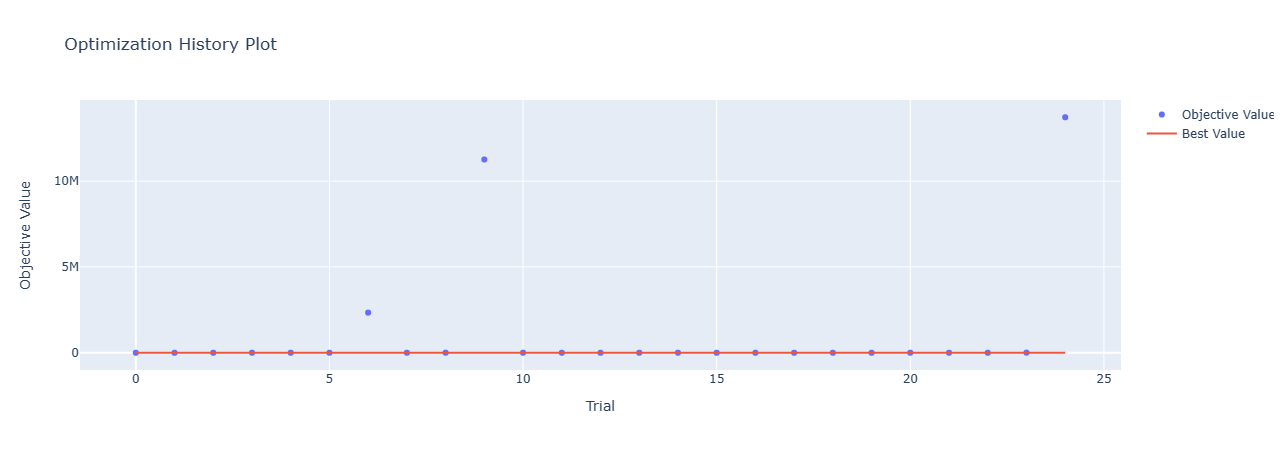

In [45]:
optuna.visualization.plot_optimization_history(study)

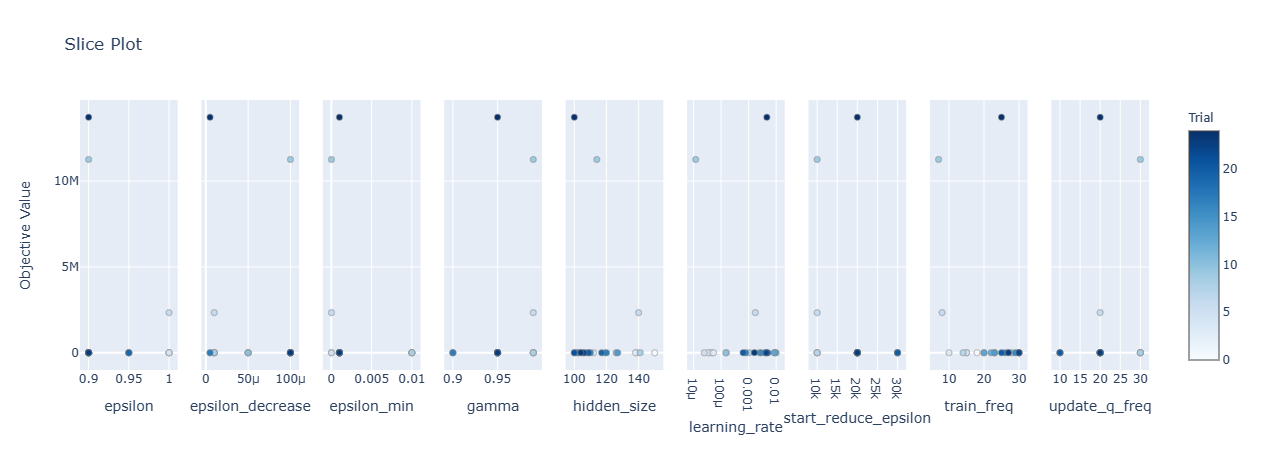

In [46]:
optuna.visualization.plot_slice(study)

In [28]:
epoch_num = 100

In [48]:
env = Environment1(train)
hyperparameters = dict(trial.params.items())
Q, total_losses, total_rewards = train_dqn(env = env, show_log_freq = show_log_freq,epoch_num =  epoch_num,memory_size = memory_size, **hyperparameters)

5	0.9	13585	-308.2	55.321878269035366	118.02779459953308
10	0.18310000000007898	27170	-132.0	38.43952443627641	126.95634460449219
15	0.0009000000000828265	40755	423.0	54.78835828050505	176.06083703041077
20	0.0009000000000828265	54340	434.0	46.71949621522799	170.59557247161865
25	0.0009000000000828265	67925	469.2	49.78503870666027	170.59931230545044
30	0.0009000000000828265	81510	488.6	42.8664109600475	170.60956501960754
35	0.0009000000000828265	95095	474.0	44.71012910183053	168.96731901168823
40	0.0009000000000828265	108680	476.4	39.99741202238947	168.85696578025818
45	0.0009000000000828265	122265	438.6	66.93420373236295	188.79083704948425
50	0.0009000000000828265	135850	495.2	39.753247738443314	165.96046590805054
55	0.0009000000000828265	149435	461.8	48.687873155050326	178.36415243148804
60	0.0009000000000828265	163020	468.6	42.236320429932675	168.69773125648499
65	0.0009000000000828265	176605	452.0	331.6559307284653	178.05463647842407
70	0.0009000000000828265	190190	479.8	35.1296865

In [28]:
def plot_loss_reward(total_losses, total_rewards):

    figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
    figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
    figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
    figure['layout']['xaxis1'].update(title='epoch')
    figure['layout']['xaxis2'].update(title='epoch')
    figure['layout'].update(height=400, width=900, showlegend=False)
    iplot(figure)

/opt/conda/lib/python3.10/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



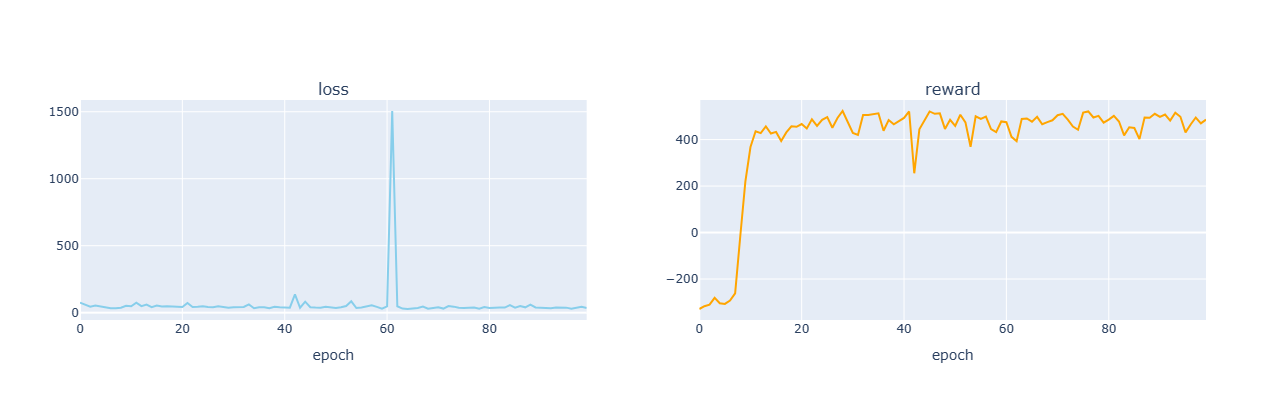

In [50]:
plot_loss_reward(total_losses, total_rewards)

In [29]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    
    # train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []

    for _ in range(len(train_env.data)-1):
        
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.numpy())
        train_acts.append(pact)
            
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs
        
    train_profits = train_env.profits
    
    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.numpy())
        test_acts.append(pact)
            
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs
        
    test_profits = test_env.profits
    
    # Calculate percentage returns
    train_investment = train_env.total_investment
    test_investment = test_env.total_investment
    train_percentage_returns = (train_profits /( train_investment + 1e-9) ) * 100
    test_percentage_returns = (test_profits / (test_investment+ 1e-9)) * 100
    
    # plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    test2 = test_copy[test_copy['act'] == 2]
    act_color0, act_color1, act_color2 = 'lightblue', 'lightgreen', 'coral'

    data = [
        Candlestick(x=train0.index, open=train0['Open'], high=train0['High'], low=train0['Low'], close=train0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=train1.index, open=train1['Open'], high=train1['High'], low=train1['Low'], close=train1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=train2.index, open=train2['Open'], high=train2['High'], low=train2['Low'], close=train2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2))),
        Candlestick(x=test0.index, open=test0['Open'], high=test0['High'], low=test0['Low'], close=test0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=test1.index, open=test1['Open'], high=test1['High'], low=test1['Low'], close=test1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=test2.index, open=test2['Open'], high=test2['High'], low=test2['Low'], close=test2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]
    title = '{}: train s-reward {}, profits {}, returns {:.2f}%, test s-reward {}, profits {}, return on investment {:.2f}%'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        train_percentage_returns,
        int(sum(test_rewards)),
        int(test_profits),
        test_percentage_returns
    )
    layout = {
        'title': title,
        'showlegend': False,
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)

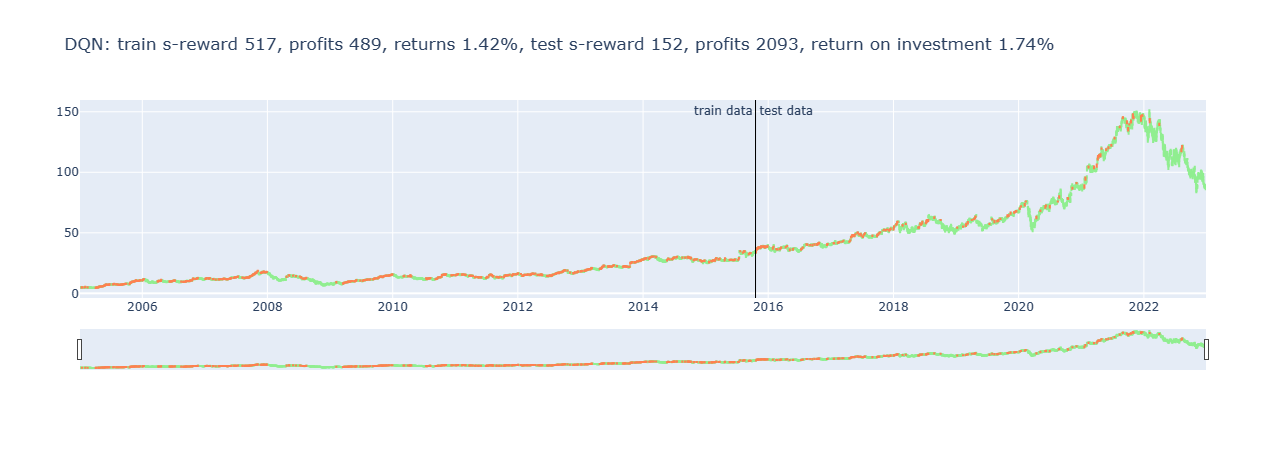

In [52]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'DQN')

In [84]:
hyperparameters = {"hidden_size": 100,
    "epsilon": 1,
    "epsilon_decrease": 1e-3,
    "epsilon_min": 0.01,
    "start_reduce_epsilon": 500,
    "train_freq": 10,
    "update_q_freq": 20,
    "gamma": 0.97,
    "learning_rate": 0.00001}

In [85]:
# Double DQN

def train_ddqn(env, hidden_size, memory_size, epsilon, epsilon_decrease, epsilon_min,
              start_reduce_epsilon, train_freq, update_q_freq, gamma, show_log_freq, epoch_num , learning_rate):


    Q = Q_Network(input_size=env.history_t+1, hidden_size=hidden_size, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    with tf.device('/gpu:0'):
        for epoch in range(epoch_num):

            pobs = env.reset()
            step = 0
            done = False
            total_reward = 0
            total_loss = 0

            while not done and step < step_max:

                # select act
                pact = np.random.randint(3)
                if np.random.rand() > epsilon:
                    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                    pact = np.argmax(pact.numpy())

                # act
                obs, reward, done = env.step(pact)

                # add memory
                memory.append((pobs, pact, reward, obs, done))
                if len(memory) > memory_size:
                    memory.pop(0)

                # train or update q
                if len(memory) == memory_size:
                    if total_step % train_freq == 0:
                        shuffled_memory = np.array(memory, dtype=object)
                        shuffled_memory = np.random.permutation(memory)
                        memory_idx = range(len(shuffled_memory))
                        for i in memory_idx[::batch_size]:
                            batch = np.array(shuffled_memory[i:i+batch_size])
                            b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                            b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                            b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                            b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                            b_done = np.array(batch[:, 4].tolist(), dtype=bool)
                            
                            with tf.GradientTape() as tape:
                                q = Q(b_pobs)
                                """ <<< DQN -> Double DQN
                                maxq = np.max(Q_ast(b_obs).data, axis=1)
                                === """
                                indices = np.argmax(q.numpy(), axis=1)
                                maxqs = Q_ast(b_obs).numpy()
                                target = copy.deepcopy(q.numpy())
                                for j in range(batch_size):
                                    """ <<< DQN -> Double DQN
                                    target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                                    === """
                                    target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                                    """ >>> """
                                loss = tf.reduce_mean(tf.square(q - target))
                                
                            total_loss += loss.numpy()
                            variables = Q.trainable_variables
                            gradients = tape.gradient(loss, variables)
                            optimizer.apply_gradients(zip(gradients, variables))   
                                

                    if total_step % update_q_freq == 0:
                        Q_ast = copy.deepcopy(Q)

                # epsilon
                if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                    epsilon -= epsilon_decrease

                # next step
                total_reward += reward
                pobs = obs
                step += 1
                total_step += 1

            total_rewards.append(total_reward)
            total_losses.append(total_loss)

            if (epoch+1) % show_log_freq == 0:
                log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
                log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
                elapsed_time = time.time()-start
                print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
                start = time.time()

        return Q, total_losses, total_rewards

In [86]:
epoch_num = 100

In [87]:
env = Environment1(train)
#hyperparameters = dict(trial.params.items())
Q, total_losses, total_rewards = train_ddqn(env = env, show_log_freq = show_log_freq,epoch_num =  epoch_num,memory_size = memory_size, **hyperparameters)

/tmp/ipykernel_28/2654571206.py:50: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



5	0.00999999999999912	13585	-71.4	62.04493634284008	160.57897520065308
10	0.00999999999999912	27170	-2.6	6.84311968992697	160.624272108078
15	0.00999999999999912	40755	3.6	2.239539802778745	160.2518846988678
20	0.00999999999999912	54340	4.6	1.9612243221592507	160.95554304122925
25	0.00999999999999912	67925	4.6	2.5494457148262883	161.99801421165466
30	0.00999999999999912	81510	7.0	2.2394204920790797	160.84592843055725
35	0.00999999999999912	95095	7.0	1.019342556897027	160.34531354904175
40	0.00999999999999912	108680	4.8	2.533120788769156	160.53611421585083
45	0.00999999999999912	122265	7.8	1.8187523346925445	161.22916722297668
50	0.00999999999999912	135850	3.6	0.9986059719809418	159.75111770629883
55	0.00999999999999912	149435	6.6	1.3800245489059306	160.88346076011658
60	0.00999999999999912	163020	12.4	1.5631574247843674	160.7233271598816
65	0.00999999999999912	176605	6.4	0.9280962910426751	161.24498558044434
70	0.00999999999999912	190190	6.4	0.7796357791794435	161.67892909049988
75	0.0

/opt/conda/lib/python3.10/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



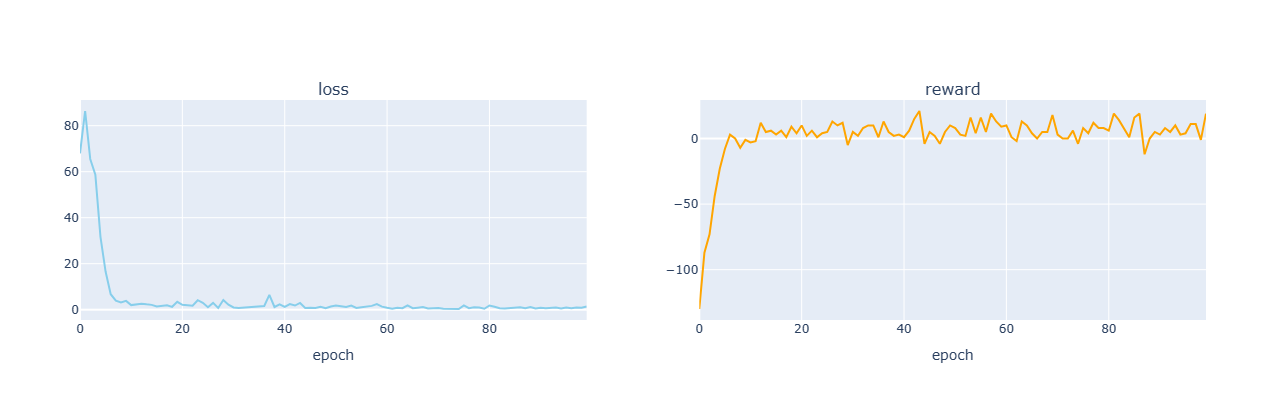

In [88]:
plot_loss_reward(total_losses, total_rewards)

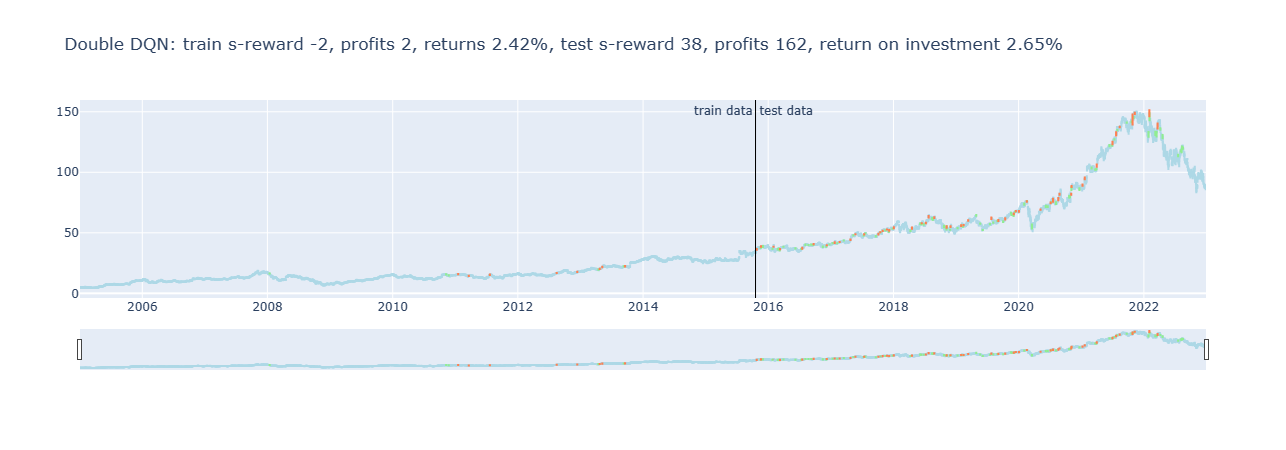

In [89]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'Double DQN')